### This code approximates the DM-IGM distribution in Jaroszynski (2019), compares it to the one in Zhang et al. (2021).
### The median DM-host evolution is also fit below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import lognorm, norm, rv_continuous
from frb.dm import igm
from scipy.optimize import curve_fit

c:\Users\Om\Box\FRB Research\frb-cosmic-evol\frb\halos\hmf.py:51: UserWarning: hmf_emulator not imported.  Hope you are not intending to use the hmf.py module..
  warnings.warn("hmf_emulator not imported.  Hope you are not intending to use the hmf.py module..")


In [3]:
class sknorm(rv_continuous):
    """
    Defined in Jones & Pewsey (2009) and also explained at: https://stats.stackexchange.com/questions/43482/transformation-to-increase-kurtosis-and-skewness-of-normal-r-v
    epsilon: Skewness parameter; positive skew with epsilon > 0
    delta: Kurtosis parameter; delta < 1 yields heavier tails than normal distribution
    """
    def _pdf(self, x, epsilon, delta, mu,sigma):
        return norm.pdf(np.sinh(delta*np.arcsinh((x-mu)/sigma)-epsilon))*delta*np.cosh(delta*np.arcsinh((x-mu)/sigma)-epsilon)/np.sqrt(1+np.power((x-mu)/sigma,2)) / sigma
    def _rvs(self, epsilon, delta, mu, sigma, size=None, random_state=None):
        z = norm.rvs(size=size)
        return np.sinh((np.arcsinh(z)+epsilon)/delta)*sigma + mu

def fit_epsilon(DM):
    return -0.07956594 * DM**0.2039934 + 0.5996404

def fit_delta(DM):
    return 1 - 0.19028718*np.exp(-0.00040967*DM)

def fit_sigmaDM(DM):
    return 3.14917494 * DM**0.49460562

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [4]:
dmigmsk_sm = np.logspace(-2, 4, 121)
dmavgigm_sm = np.zeros(dmigmsk_sm.shape[0])
sk = sknorm("Skew Kurtosis Distribution")
for i in range(dmigmsk_sm.shape[0]):
    eps_use = fit_epsilon(dmigmsk_sm[i])
    del_use = fit_delta(dmigmsk_sm[i])
    sk_use = sk.rvs(epsilon=eps_use, delta=del_use, mu=dmigmsk_sm[i], sigma=fit_sigmaDM(dmigmsk_sm[i]), size=1000000)
    dmavgigm_sm[i] = np.mean(sk_use)
dmigm_diff = dmavgigm_sm-dmigmsk_sm

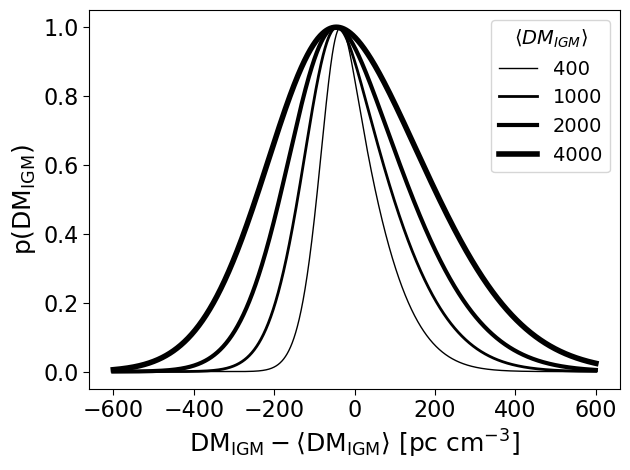

In [5]:
mean_dmigm = np.array([400, 1000, 2000, 4000])
base_dmigm = np.linspace(-600, 600, 2000)
fig, ax = plt.subplots(1,1)
for j in range(mean_dmigm.shape[0]):
    dmavg, idx_dmdiff = find_nearest(dmavgigm_sm, mean_dmigm[j])
    dmsk_mu = mean_dmigm[j] - dmigm_diff[idx_dmdiff]
    eps_use = fit_epsilon(dmsk_mu)
    del_use = fit_delta(dmsk_mu)
    scale_use = fit_sigmaDM(dmsk_mu)
    x_dmigm = np.linspace(mean_dmigm[j]-600, mean_dmigm[j]+600, 2000)
    dmigmpdf = sk.pdf(x=x_dmigm, epsilon=eps_use, delta=del_use, mu=dmsk_mu, sigma=scale_use)
    ax.plot(base_dmigm, dmigmpdf/np.max(dmigmpdf), linewidth=j+1, color='k', label="{}".format(mean_dmigm[j]))
    
ax.set_xlabel(r"$\rm DM_{IGM}-\langle DM_{IGM} \rangle$ [pc cm$^{-3}$]", fontsize=18)
ax.set_ylabel(r"$\rm p(DM_{IGM})$", fontsize=18)
ax.tick_params(axis='both', which='major', length=4, labelsize=16)
# ax.tick_params(axis='both', which='minor', length=4)
plt.legend(title=r"$\langle DM_{{IGM}} \rangle$", fontsize=14, title_fontsize=14)
plt.tight_layout()
plt.show()

### Generate Figure 10 of Gupta et al. (2025)

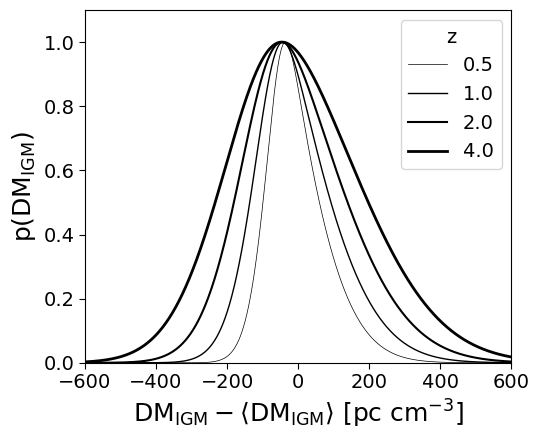

In [6]:
z_dmigm = np.array([0.5, 1, 2, 4])
mean_dmigm = np.array([igm.average_DM(z).value for z in z_dmigm])
base_dmigm = np.linspace(-600, 600, 2000)
fig, ax = plt.subplots(1,1, figsize=(5.5,4.5))
for j in range(mean_dmigm.shape[0]):
    dmavg, idx_dmdiff = find_nearest(dmavgigm_sm, mean_dmigm[j])
    dmsk_mu = mean_dmigm[j] - dmigm_diff[idx_dmdiff]
    eps_use = fit_epsilon(dmsk_mu)
    del_use = fit_delta(dmsk_mu)
    scale_use = fit_sigmaDM(dmsk_mu)
    x_dmigm = np.linspace(mean_dmigm[j]-600, mean_dmigm[j]+600, 2000)
    dmigmpdf = sk.pdf(x=x_dmigm, epsilon=eps_use, delta=del_use, mu=dmsk_mu, sigma=scale_use)
    # print()
    ax.plot(base_dmigm, dmigmpdf/np.max(dmigmpdf), linewidth=(j+1)*0.5, color='k', label="{}".format(z_dmigm[j]))
    
ax.set_xlabel(r"$\rm DM_{IGM}-\langle DM_{IGM} \rangle$ [pc cm$^{-3}$]", fontsize=18)
ax.set_ylabel(r"$\rm p(DM_{IGM})$", fontsize=18)
ax.tick_params(axis='both', which='major', length=4, labelsize=14)
ax.set_xlim([-600, 600])
ax.set_ylim([0, 1.1])
# ax.tick_params(axis='both', which='minor', length=4)
plt.legend(title="z", fontsize=14, title_fontsize=14)
plt.tight_layout()
plt.show()

### Compare DM-IGM distributions from Jaroszynski (2019) with Zhang et al. (2021)

In [5]:
def tailedgaussian(x, A, C0, sigmaDM, alpha=3, beta=3):
    return A * x**(-beta) * np.exp(- (x**(-alpha) - C0)**2 / (2*alpha**2 * sigmaDM**2))

(200, 8000)

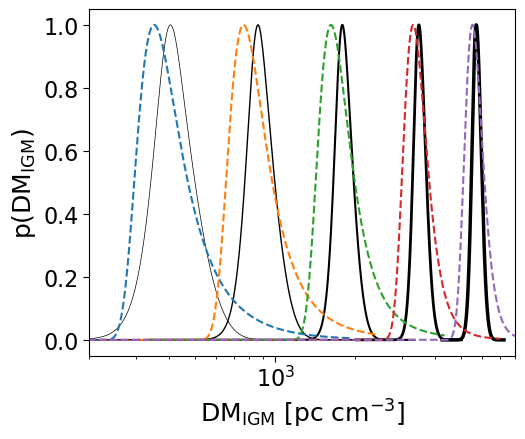

In [30]:
fig, ax = plt.subplots(1,1, figsize=(5.5,4.5))
for j in range(5):
    dmavg, idx_dmdiff = find_nearest(dmavgigm_sm, mean_dmigm[j])
    dmsk_mu = mean_dmigm[j] - dmigm_diff[idx_dmdiff]
    eps_use = fit_epsilon(dmsk_mu)
    del_use = fit_delta(dmsk_mu)
    scale_use = fit_sigmaDM(dmsk_mu)
    x_dmigm = np.linspace(mean_dmigm[j]-1500, mean_dmigm[j]+1500, 2000)
    dmigmpdf = sk.pdf(x=x_dmigm, epsilon=eps_use, delta=del_use, mu=dmsk_mu, sigma=scale_use)
    # print()
    ax.plot(x_dmigm, dmigmpdf/np.max(dmigmpdf), linewidth=(j+1)*0.5, color='k', label="{}".format(z_dmigm[j]))

tg1 = tailedgaussian(np.linspace(mean_dmigm[0]-600, mean_dmigm[0]+1500, 2000)/mean_dmigm[0], 0.002423, 1.127, 0.4306)
tg2 = tailedgaussian(np.linspace(mean_dmigm[1]-600, mean_dmigm[1]+1500, 2000)/mean_dmigm[1], 0.001456, 1.189, 0.3044)
tg3 = tailedgaussian(np.linspace(mean_dmigm[2]-1500, mean_dmigm[2]+2500, 2000)/mean_dmigm[2], 0.0009672, 1.162, 0.2160)
tg4 = tailedgaussian(np.linspace(mean_dmigm[3]-3500, mean_dmigm[3]+3500, 2000)/mean_dmigm[3], 0.0008826, 1.092, 0.1233)
tg5 = tailedgaussian(np.linspace(mean_dmigm[4]-6000, mean_dmigm[4]+6000, 2000)/mean_dmigm[4], 0.0008881, 1.066, 0.08944)
ax.plot(np.linspace(mean_dmigm[0]-600, mean_dmigm[0]+1500, 2000), tg1/np.max(tg1), linestyle='--')
ax.plot(np.linspace(mean_dmigm[1]-600, mean_dmigm[1]+1500, 2000), tg2/np.max(tg2), linestyle='--')
ax.plot(np.linspace(mean_dmigm[2]-1500, mean_dmigm[2]+2500, 2000), tg3/np.max(tg3), linestyle='--')
ax.plot(np.linspace(mean_dmigm[3]-3500, mean_dmigm[3]+3500, 2000), tg4/np.max(tg4), linestyle='--')
ax.plot(np.linspace(mean_dmigm[4]-6000, mean_dmigm[4]+6000, 2000), tg5/np.max(tg5), linestyle='--')

ax.set_xscale('log')
ax.set_xlabel(r"$\rm DM_{IGM}$ [pc cm$^{-3}$]", fontsize=18)
ax.set_ylabel(r"$\rm p(DM_{IGM})$", fontsize=18)
ax.tick_params(axis='both', which='major', length=4, labelsize=16)
ax.set_xlim([200, 8000])

### Plot the evolution of median DM-host for SFR-tracking and SMD-tracking populations from Mo et al. (2023)

[155.94459847 179.84888324  -1.01988608] [[ 1.28225723e+01 -7.01409793e+00  1.49931412e-01]
 [-7.01409793e+00  3.33472386e+01  2.06682290e-01]
 [ 1.49931412e-01  2.06682290e-01  5.70863761e-03]]
[ 59.5916731  293.00474447  -0.60957209] [[6.85359072e+00 5.99463434e+00 6.02295526e-02]
 [5.99463434e+00 1.16014411e+02 3.95143123e-01]
 [6.02295526e-02 3.95143123e-01 1.68178681e-03]]


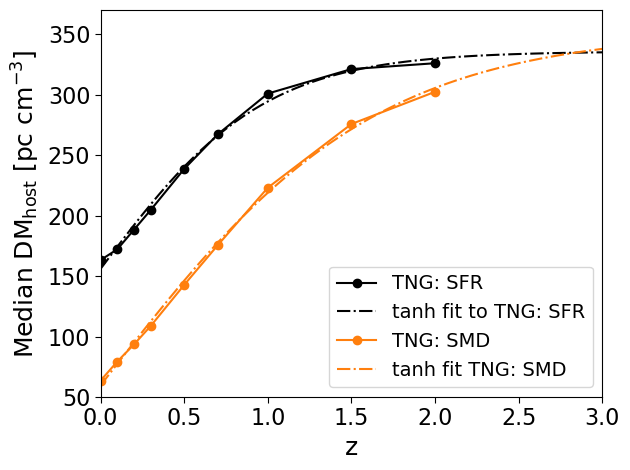

In [8]:
df = pd.read_csv("files/zhu_dmhost.csv")
z_jaro20 = np.array([0, 0.2, 0.5, 0.7, 1, 2, 3])
dmh_jaro20 = np.array([83,93,133, 174,198,370,471])
z_dmh = np.linspace(0,5,100)

def fit_tanh(z, a, b, c):
    return a + b*np.tanh(-c*z)

fig, ax = plt.subplots(1,1)
ax.plot(df['z'], df['dmh_mean_tngsfr'], '-o', label="TNG: SFR", color='k')
popt3, pcov3 = curve_fit(fit_tanh, df['z'], df['dmh_mean_tngsfr'])
print(popt3, pcov3)
popt4, pcov4 = curve_fit(fit_tanh, df['z'], df['dmh_mean_tngsmd'])
print(popt4, pcov4)
# plt.plot(z_dmh, 176*(1+z_dmh)**0.627, '--', label="TNG-SFR Mo+23 fit", color='C0')
# plt.plot(z_dmh, 86*(1+z_dmh)**1.3, '--', label="TNG-SMD Mo+23 fit", color='C1')

ax.plot(z_dmh, fit_tanh(z_dmh, *popt3), '-.', label="tanh fit to TNG: SFR", color='k')

ax.plot(df['z'], df['dmh_mean_tngsmd'], '-o', label="TNG: SMD", color='C1')
ax.plot(z_dmh, fit_tanh(z_dmh, *popt4), '-.', label="tanh fit TNG: SMD", color='C1')
ax.set_ylim([50, 370])
ax.set_xlim([0,3])
ax.set_ylabel(r"Median $\rm DM_{\rm host}$ [pc cm$^{-3}$]", fontsize=18)
ax.set_xlabel("z", fontsize=18)
ax.tick_params(axis='both', which='major', length=4, labelsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()